# Classifying Cats and Dogs with Tensorflow
**Reference:** https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb
In this tutorial, we train a **ConvNet** to classify dogs and cats from a Kaggle Machine Learning Dataset


## Downloading data:
**Reference:** https://www.hostinger.mx/tutoriales/usar-comando-wget/
Downloading dataset and saving to current directory
If you execute: 

*!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip*

It willbe downloaded to folder tmp in root

In [0]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2019-08-30 20:30:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  53.0MB/s    in 1.2s    

2019-08-30 20:30:16 (53.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Unzipping the contents of local folder **data** in the location of this notebook

In [0]:
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./data')
zip_ref.close()

## Defining Training and Validation Directories
Notice directory pointing to *./data* shows that directory is located where this notebook is. But probably is a better idea to do like the course because all datasets could go to a local folder in root

In [0]:
base_dir = './data/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the cats and dogs train directories (file naming conventions are the same in the validation directory):

In [0]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.24.jpg', 'cat.555.jpg', 'cat.81.jpg', 'cat.139.jpg', 'cat.908.jpg']
['dog.557.jpg', 'dog.866.jpg', 'dog.412.jpg', 'dog.263.jpg', 'dog.346.jpg']


Total number of images in **train** and **validation** folders is:

In [0]:
print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


Visualizing images from the **Dataset**
Notice that the images are of different sizes. *Before training a Neural network with them you'll need to tweak the images. You'll see that in the next section.* Ok, now that you have an idea for what your data looks like, the next step is to define the model that will be trained to recognize cats or dogs from these images

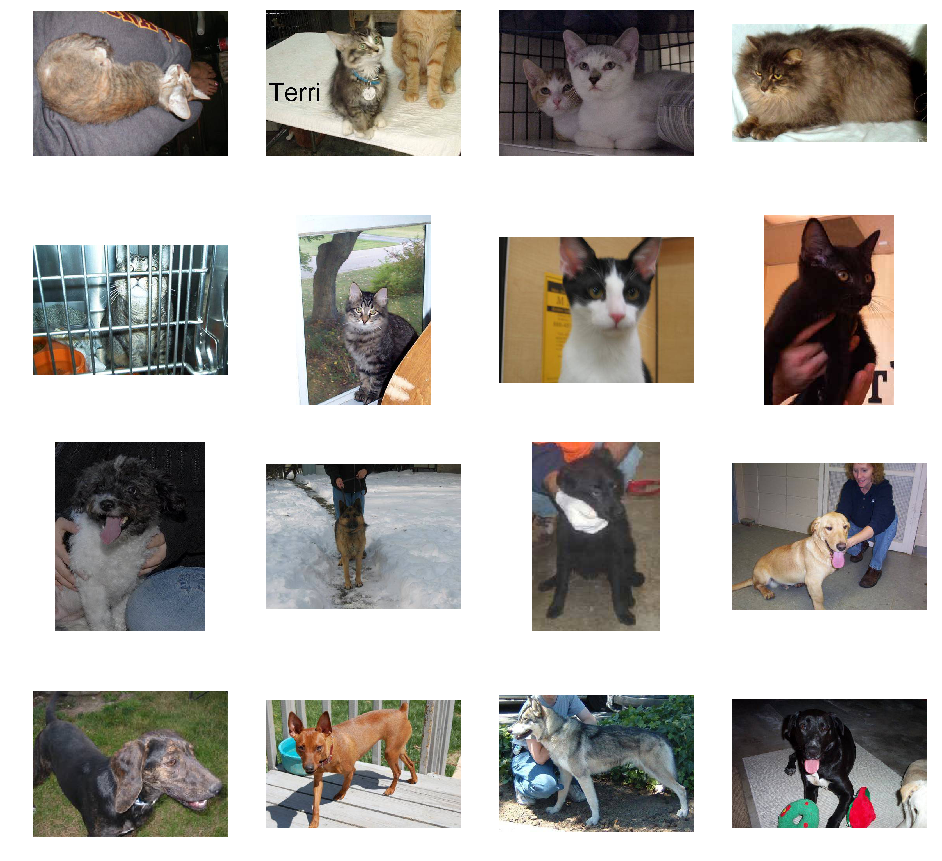

In [0]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch and with Data augmentation to reduce overfitting
Images will be pre-processed to be of 150x150x3 size. This model will be for ***binary classification***
This is working with **tensorflow 1.13.1**

In [0]:
import tensorflow as tf
print('tensorflow_version:', tf.__version__)

tensorflow_version: 1.14.0


The model has:
- input tensor of $150 \times 150 \times 3$
- convolutional layer of  $16 \times 3 \times 3$ kernel
- max pool $2 \times 2$
- convolution of $32 \times  3 \times 3 $
- max pooling 
- convolution of $64 \times  \times  3$
- max pooling
- final dense layer

*Notice in the model summary that we can read the image size change through the convnet*
"The "output shape" column shows **how the size of your feature map evolves in each successive layer**". 
"*The convolution layers reduce the size of the feature maps by a bit due to padding*, and *each pooling layer halves the dimensions*".

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.summary()

W0830 20:30:20.356110 140303411222400 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Training specifications
 - Loss: binary cross entropy
 - Optimizer: RMSPROP
 - Learning rate: 0.01
 
 **NOTE:** In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics = ['acc'])

W0830 20:30:20.630415 140303411222400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data Preprocessing
Preprocessing images will consist in:
- **Image Normalization**: Images are in range 0-255. They will be normalized to range 0 - 1 by using *rescale method* in **data generator**
- **Image Size**: Images will be standarized to size of $150 \times 150$. Method *target size* in **flow**
- **Images batch and labels:** Images are organized in batches of 20 and binary labelled with Method  **flow**

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale=1.0/255,
                                    rotation_range = 40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_datagen  = ImageDataGenerator(   rescale=1.0/255)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training:
 - epochs: 15
 - Total traning images 2000.
 - Total validation images 1000.

In [0]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=1e-2,
                                                   patience=100,
                                                   mode='auto',
                                                   verbose=1)

In [0]:
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100, # 2000 images = batch_size * steps
                              epochs=1000,
                              validation_steps=50, # 1000 images = batch_size * steps
                              callbacks=[early_stop_callback],
                              verbose=1)

Epoch 1/1000
100/100 [==============================] - 17s 173ms/step - loss: 0.6830 - acc: 0.5480 - val_loss: 0.6553 - val_acc: 0.6260
Epoch 2/1000
100/100 [==============================] - 16s 156ms/step - loss: 0.6710 - acc: 0.5855 - val_loss: 0.6874 - val_acc: 0.5490
Epoch 3/1000
100/100 [==============================] - 16s 156ms/step - loss: 0.6640 - acc: 0.5805 - val_loss: 0.6612 - val_acc: 0.5730
Epoch 4/1000
100/100 [==============================] - 16s 156ms/step - loss: 0.6401 - acc: 0.6275 - val_loss: 0.6013 - val_acc: 0.6630
Epoch 5/1000
100/100 [==============================] - 16s 157ms/step - loss: 0.6222 - acc: 0.6475 - val_loss: 0.5979 - val_acc: 0.6590
Epoch 6/1000
100/100 [==============================] - 16s 155ms/step - loss: 0.6076 - acc: 0.6655 - val_loss: 0.5844 - val_acc: 0.6840
Epoch 7/1000
100/100 [==============================] - 16s 157ms/step - loss: 0.6004 - acc: 0.6680 - val_loss: 0.5720 - val_acc: 0.6870
Epoch 8/1000
100/100 [===================

## Displaying ConvNet Layers Output

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


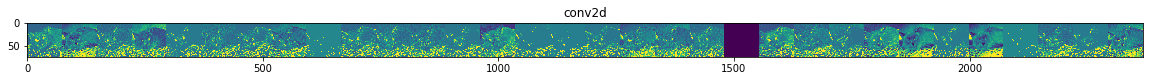

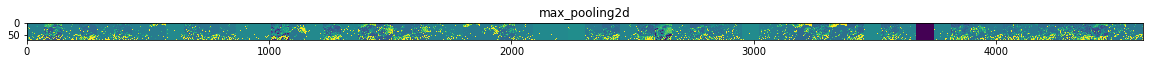

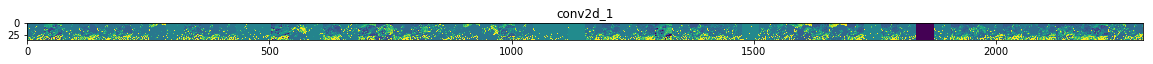

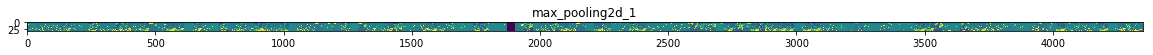

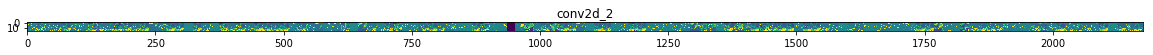

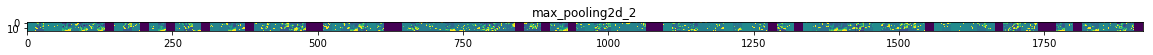

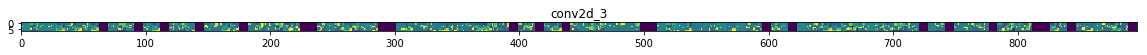

In [0]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## Model Performance

Text(0.5, 1.0, 'Training and validation loss')

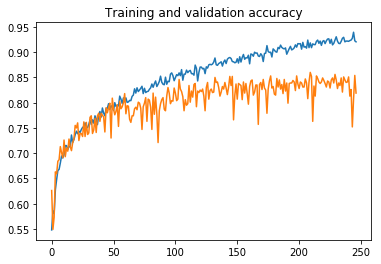

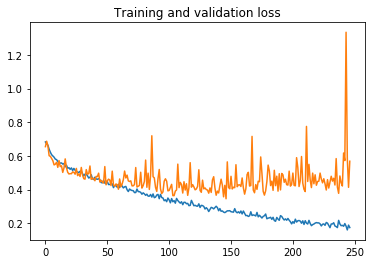

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

## Others evaluations
How to use evaluate_generator? can we display a confusion matrix?

https://github.com/keras-team/keras/issues/11902

https://medium.com/@jannik.zuern/training-a-cifar-10-classifier-in-the-cloud-using-tensorflow-and-google-colab-f3a5fbdfe24d

https://github.com/jzuern/cifar-classifier/blob/master/cifar_classifier.ipynb

https://colab.research.google.com/drive/1XvhLFD4zECIY6wLQJHDgZORVGGY2GDJa

## Clean Up

In [0]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )